In [1]:
!pip install squarify

In [2]:
!pip install catboost

In [3]:
#Import the libraries
import numpy as np
import pandas as pd
import scipy.io
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.io import loadmat
from keras.preprocessing.sequence import pad_sequences
import squarify
from imblearn.over_sampling import SMOTE
import re
from math import pi
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.utils import resample
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the .mat file
mat = loadmat(r'/content/influenza_outbreak_dataset[1].mat')

# Remove MATLAB metadata entries (keys starting with '_')
mat = {k: v for k, v in mat.items() if not k.startswith('_')}

# Flatten and convert each item into a pandas Series, then create a DataFrame
data = pd.DataFrame({key: pd.Series(value.flatten()) for key, value in mat.items()})

# Save the DataFrame to a CSV file
csv_path = r'/content/influenza_outbreak_dataset.csv'
data.to_csv(csv_path, index=False)

# Optional: Load and preview the CSV
df = pd.read_csv(csv_path)
print(df.head())


                                            flu_X_tr  \
0  <Compressed Sparse Column sparse matrix of dty...   
1  <Compressed Sparse Column sparse matrix of dty...   
2  <Compressed Sparse Column sparse matrix of dty...   
3  <Compressed Sparse Column sparse matrix of dty...   
4  <Compressed Sparse Column sparse matrix of dty...   

                                    flu_Y_tr  \
0  [[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]]   
1  [[0]\n [0]\n [0]\n ...\n [1]\n [1]\n [1]]   
2  [[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]]   
3  [[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]]   
4  [[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]]   

                                            flu_X_te  \
0  <Compressed Sparse Column sparse matrix of dty...   
1  <Compressed Sparse Column sparse matrix of dty...   
2  <Compressed Sparse Column sparse matrix of dty...   
3  <Compressed Sparse Column sparse matrix of dty...   
4  <Compressed Sparse Column sparse matrix of dty...   

                                     

In [5]:
#Dimension of dataset
df.shape

(525, 6)

In [6]:
#Checking the null value
df.isnull().sum()

,0
flu_X_tr,477
flu_Y_tr,477
flu_X_te,477
flu_Y_te,477
flu_locs,477
flu_keywords,0


In [7]:
#Checking the duplicates
df.duplicated().sum()

np.int64(0)

In [8]:
#Checking the columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   flu_X_tr      48 non-null     object
 1   flu_Y_tr      48 non-null     object
 2   flu_X_te      48 non-null     object
 3   flu_Y_te      48 non-null     object
 4   flu_locs      48 non-null     object
 5   flu_keywords  525 non-null    object
dtypes: object(6)
memory usage: 24.7+ KB


In [9]:
# Extract the first keyword safely
def extract_keyword(x):
    try:
        if isinstance(x, list):
            return x[0]
        elif isinstance(x, str):
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
    except:
        return None
    return None

# Apply to flu_keywords column
df['parsed_keywords'] = df['flu_keywords'].apply(extract_keyword)

# Drop nulls
keywords_flat = df['parsed_keywords'].dropna().tolist()


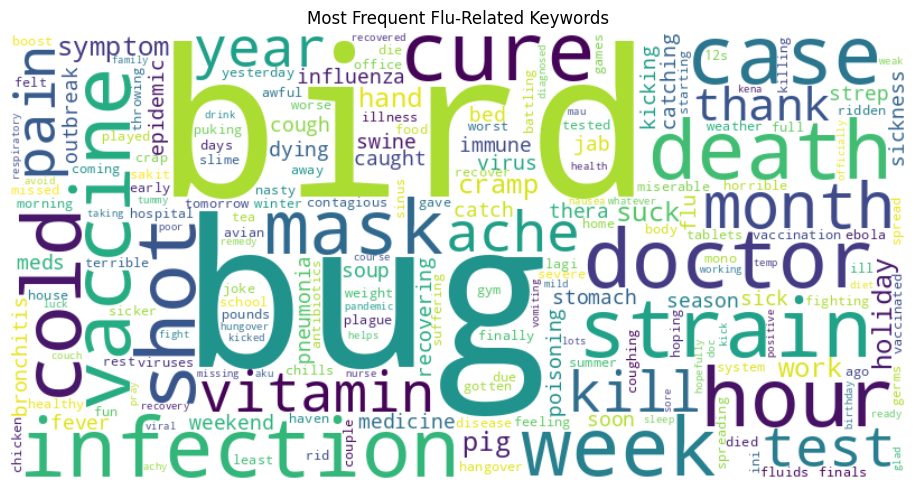

In [10]:
# WordCloud
text = " ".join(keywords_flat)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Flu-Related Keywords")
plt.tight_layout()
plt.show()


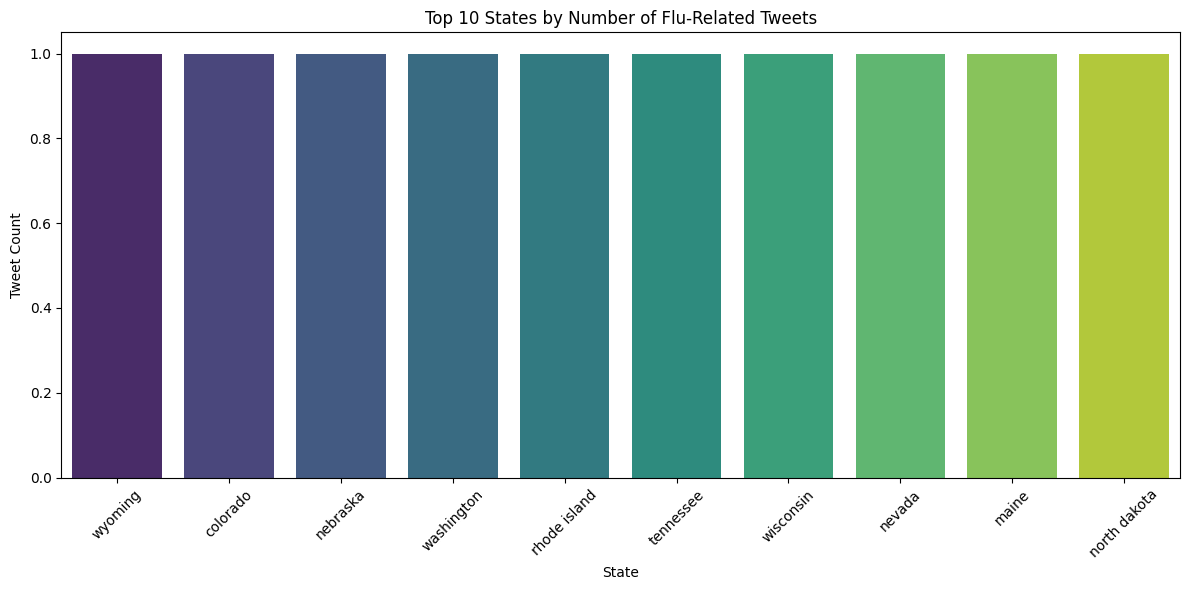

In [11]:
# Extract state
def extract_state(x):
    try:
        if isinstance(x, list):
            return x[0]
        elif isinstance(x, str):
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
    except:
        return None
    return None

# Apply the function to extract state names
df['state'] = df['flu_locs'].apply(extract_state)

# Drop rows where state couldn't be extracted
df_states = df.dropna(subset=['state'])

# Group & plot top 10 states
state_counts = df_states['state'].value_counts().reset_index()
state_counts.columns = ['State', 'Tweet Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=state_counts.head(10), x='State', y='Tweet Count', palette='viridis')
plt.title("Top 10 States by Number of Flu-Related Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


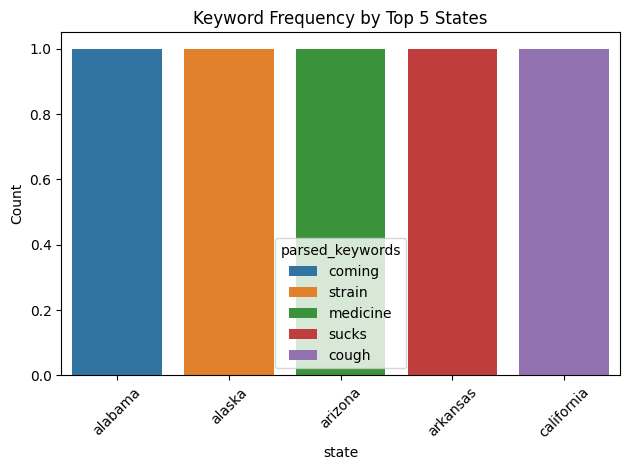

In [12]:
# Barplot
state_keyword_freq = df.groupby(['state', 'parsed_keywords']).size().reset_index(name='count')
top_states = state_keyword_freq['state'].value_counts().head(5).index
filtered = state_keyword_freq[state_keyword_freq['state'].isin(top_states)]

sns.barplot(data=filtered, x='state', y='count', hue='parsed_keywords')
plt.title("Keyword Frequency by Top 5 States")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


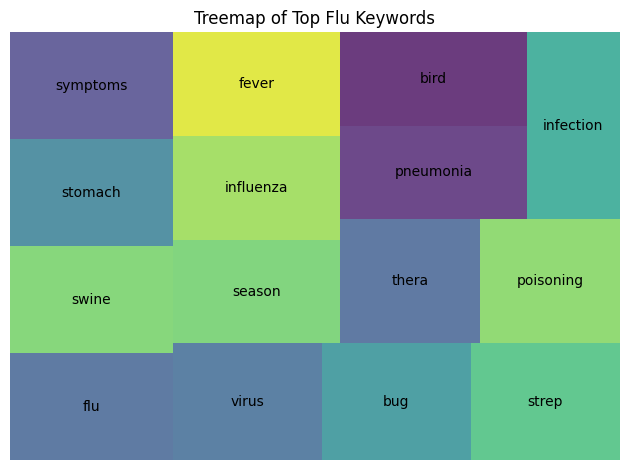

In [13]:
#Keywords
keyword_counts = Counter(keywords_flat)
top_keywords = dict(keyword_counts.most_common(15))

squarify.plot(sizes=top_keywords.values(), label=top_keywords.keys(), alpha=.8)
plt.title("Treemap of Top Flu Keywords")
plt.axis('off')
plt.tight_layout()
plt.show()




In [14]:
def get_max_index(column):
    max_index = 0
    for row in column:
        if pd.isna(row) or not isinstance(row, str) or ':' not in row:
            continue  # skip non-strings or malformed entries
        try:
            indices = [int(item.split(':')[0]) for item in row.strip().split() if ':' in item]
            if indices:
                max_index = max(max_index, max(indices))
        except ValueError:
            continue  # skip rows that still cause issues
    return max_index

max_feature_index = max(get_max_index(df['flu_X_tr']), get_max_index(df['flu_X_te']))

In [15]:
#Parsed sparse column
def parse_sparse_column(col, vector_size):
    vecs = []
    for row in col:
        vec = np.zeros(vector_size)
        if isinstance(row, str):
            entries = re.findall(r"\((\d+), 0\)\t([\d\.]+)", row)
            for idx, val in entries:
                i = int(idx)
                if i < vector_size:
                    vec[i] = float(val)
        vecs.append(vec)
    return vecs

df['X_tr_parsed'] = parse_sparse_column(df['flu_X_tr'], max_feature_index + 1)
df['X_te_parsed'] = parse_sparse_column(df['flu_X_te'], max_feature_index + 1)


In [16]:
#first 5 rows of dataset
df.head()

,flu_X_tr,flu_Y_tr,flu_X_te,flu_Y_te,flu_locs,flu_keywords,parsed_keywords,state,X_tr_parsed,X_te_parsed
0,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['wyoming'],['flu'],flu,wyoming,[0.0],[0.0]
1,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [1]\n [1]\n [1]],<Compressed Sparse Column sparse matrix of dty...,[[1]\n [1]\n [1]\n [0]\n [0]\n [0]\n [0]\n [0]...,['colorado'],['swine'],swine,colorado,[4.0],[2.0]
2,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['nebraska'],['stomach'],stomach,nebraska,[0.0],[1.0]
3,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['washington'],['symptoms'],symptoms,washington,[2.0],[3.0]
4,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['rhode island'],['virus'],virus,rhode island,[0.0],[0.0]


In [17]:
#Extract labels
def extract_labels(column):
    labels = []
    for row in column:
        try:
            arr = ast.literal_eval(row)
            flat = [item[0] if isinstance(item, list) else item for item in arr]
            label = max(set(flat), key=flat.count) if flat else 0  # Use most common label
            labels.append(label)
        except:
            labels.append(0)  # Fallback
    return labels

df['Y_tr_label'] = extract_labels(df['flu_Y_tr'])
df['Y_te_label'] = extract_labels(df['flu_Y_te'])


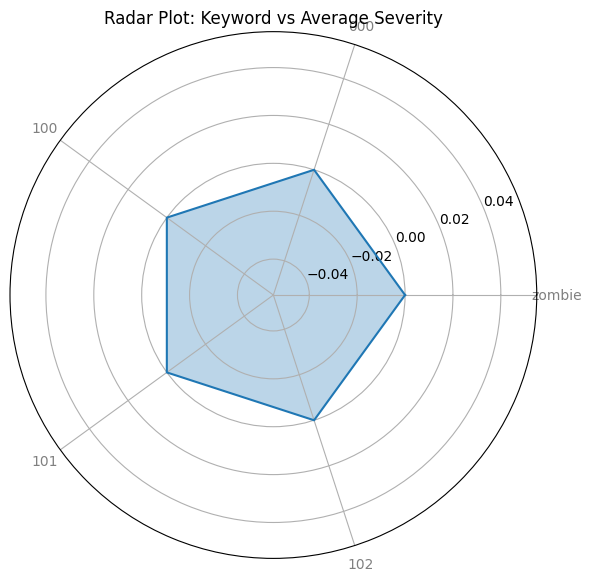

In [18]:
#Average keywords
avg_keyword_sev = df.groupby('parsed_keywords')['Y_tr_label'].mean().sort_values(ascending=False).head(5)
labels = avg_keyword_sev.index.tolist()
values = avg_keyword_sev.values

# Prepare radar format
categories = list(labels)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
values = list(values) + [values[0]]
angles += [angles[0]]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.3)
plt.title("Radar Plot: Keyword vs Average Severity")
plt.tight_layout()
plt.show()






In [19]:
#First 5 rows of dataset
df.head()

,flu_X_tr,flu_Y_tr,flu_X_te,flu_Y_te,flu_locs,flu_keywords,parsed_keywords,state,X_tr_parsed,X_te_parsed,Y_tr_label,Y_te_label
0,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['wyoming'],['flu'],flu,wyoming,[0.0],[0.0],0,0
1,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [1]\n [1]\n [1]],<Compressed Sparse Column sparse matrix of dty...,[[1]\n [1]\n [1]\n [0]\n [0]\n [0]\n [0]\n [0]...,['colorado'],['swine'],swine,colorado,[4.0],[2.0],0,0
2,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['nebraska'],['stomach'],stomach,nebraska,[0.0],[1.0],0,0
3,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['washington'],['symptoms'],symptoms,washington,[2.0],[3.0],0,0
4,<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n ...\n [0]\n [0]\n [0]],<Compressed Sparse Column sparse matrix of dty...,[[0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]\n [0]...,['rhode island'],['virus'],virus,rhode island,[0.0],[0.0],0,0


In [20]:
# Simulate some minority class data
df_majority = df[df['Y_tr_label'] == 0]
df_minority = df[df['Y_tr_label'] == 1]
df_minority_simulated = df_majority.sample(100, random_state=42).copy()
df_minority_simulated['Y_tr_label'] = 1

# Combine with original majority class
df_combined = pd.concat([df, df_minority_simulated])
print(df_combined['Y_tr_label'].value_counts())

# Upsample
df_majority = df_combined[df_combined['Y_tr_label'] == 0]
df_minority = df_combined[df_combined['Y_tr_label'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=100,  # You can increase this as needed
    random_state=42
)

# Combine
df_balanced = pd.concat([df_majority, df_minority_upsampled])
# Pad the sequences in 'X_tr_parsed' to a uniform length
X_train_padded = pad_sequences(df_balanced['X_tr_parsed'].tolist(), padding='post', dtype='float32')

# Now, you can safely convert it into a numpy array
X_train = np.array(X_train_padded)
y_train = df_balanced['Y_tr_label'].values


Y_tr_label
0    525
1    100
Name: count, dtype: int64


In [21]:
#X_train
X_train

array([[ 0.],
       [ 4.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 3.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 3.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 5.],
       [ 1.],
       [ 1.],
       [ 3.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 4.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 0.],
       [ 1.],
       [12.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 3.],
       [ 6.],
       [ 1.],
       [ 5.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
      

In [22]:
#y_train
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
# Sample 50 class-1 rows from upsampled training data
df_test_minority = df_minority_upsampled.sample(n=50, random_state=42).copy()
df_test_minority['X_te_parsed'] = df_test_minority['X_tr_parsed']
df_test_minority['Y_te_label'] = df_test_minority['Y_tr_label']  # <-- important fix

# Sample 200 class-0 rows from original test set
df_test_majority = df[df['Y_te_label'] == 0].sample(n=200, random_state=42)

# Combine both to form balanced test set
df_test_balanced = pd.concat([df_test_majority, df_test_minority], ignore_index=True)

X_test = np.array(df_test_balanced['X_te_parsed'].tolist())
y_test = df_test_balanced['Y_te_label'].tolist()


In [24]:
#Unique Count for y_train
y_train = pd.Series(y_train)
print(y_train.value_counts())

0    525
1    100
Name: count, dtype: int64


In [25]:
#y_test
y_test

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [26]:
# Convert the list to a pandas Series
y_test = pd.Series(y_test)

# Use value_counts() to get the frequency of each unique value
value_counts = y_test.value_counts()

# Display the result
print(value_counts)

0    200
1     50
Name: count, dtype: int64


In [27]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)  # Adjust features if needed

# Apply TF-IDF on your text column (e.g., 'flu_keywords')
X_tfidf = tfidf.fit_transform(df['flu_keywords'])


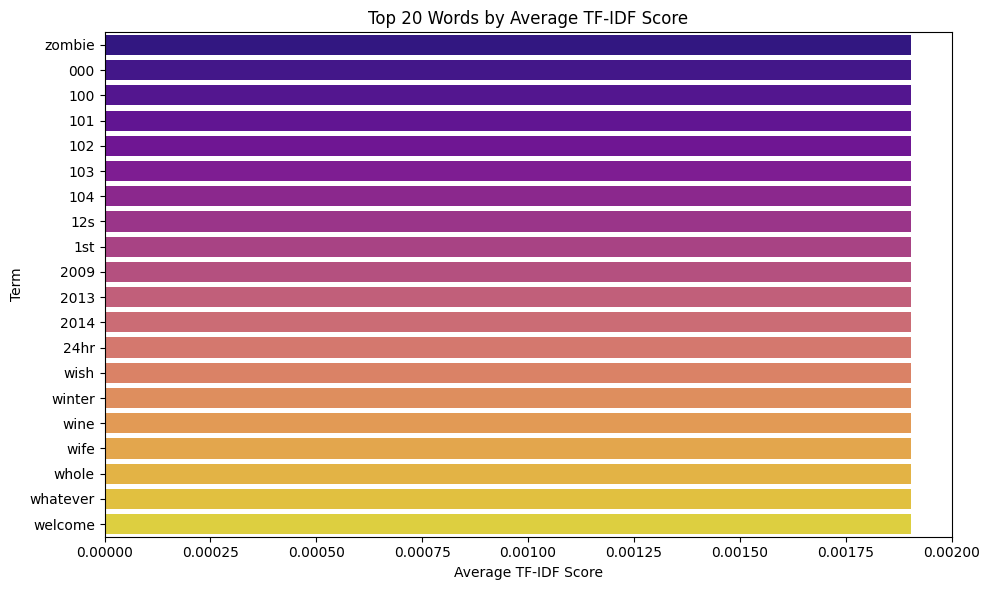

In [28]:
# Get feature names and their mean TF-IDF scores
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
top_n = 20  # Top N words

# Create DataFrame
top_features = pd.DataFrame({
    'term': tfidf.get_feature_names_out(),
    'tfidf': tfidf_means
}).sort_values(by='tfidf', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='tfidf', y='term', palette='plasma')
plt.title("Top 20 Words by Average TF-IDF Score")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Term")
plt.tight_layout()
plt.show()


In [29]:
# ===  Apply SMOTE to balance classes ===
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
#y_train
y_train.value_counts()

,count
0,525
1,525


In [31]:
# Random Forest
# ===  Random Forest Training with Grid Search ===
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 150],
    "max_depth": [5, 10],
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', verbose=0)
grid_rf.fit(X_train, y_train)

print(f" Best Parameters for Random Forest: {grid_rf.best_params_}")

# ===  Prediction & Evaluation ===
y_pred_rf = grid_rf.predict(X_test)
y_proba_rf = grid_rf.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)

try:
    auc_roc_rf = roc_auc_score(y_test, y_proba_rf)
except ValueError:
    auc_roc_rf = "AUC undefined (only one class in y_test)"

# === Final Output ===
print("\n Evaluation Metrics:")
print(f"1. Accuracy   : {accuracy_rf:.4f}")
print(f"2. Precision  : {precision_rf:.4f}")
print(f"3. Recall     : {recall_rf:.4f}")
print(f"4. F1-Score   : {f1_rf:.4f}")
print(f"5. AUC-ROC    : {auc_roc_rf}")


 Best Parameters for Random Forest: {'max_depth': 5, 'n_estimators': 100}

 Evaluation Metrics:
1. Accuracy   : 0.8040
2. Precision  : 0.5455
3. Recall     : 0.1200
4. F1-Score   : 0.1967
5. AUC-ROC    : 0.5738


In [32]:
# ===  Train XGBoost with Grid Search ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_xgb = {
    "n_estimators": [100, 150],
    "learning_rate": [0.1, 0.05]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='f1')
grid_xgb.fit(X_train, y_train)

print(f" Best Parameters for XGBoost: {grid_xgb.best_params_}")

# ===  Predict & Evaluate ===
y_pred_xgb = grid_xgb.predict(X_test)
y_proba_xgb = grid_xgb.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, zero_division=0)

try:
    auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb)
except ValueError:
    auc_roc_xgb = "AUC undefined (only one class in y_test)"

# === Final Output ===
print("\n Evaluation Metrics for XGBoost:")
print(f"1. Accuracy   : {accuracy_xgb:.4f}")
print(f"2. Precision  : {precision_xgb:.4f}")
print(f"3. Recall     : {recall_xgb:.4f}")
print(f"4. F1-Score   : {f1_xgb:.4f}")
print(f"5. AUC-ROC    : {auc_roc_xgb}")


 Best Parameters for XGBoost: {'learning_rate': 0.05, 'n_estimators': 100}

 Evaluation Metrics for XGBoost:
1. Accuracy   : 0.7840
2. Precision  : 0.3750
3. Recall     : 0.1200
4. F1-Score   : 0.1818
5. AUC-ROC    : 0.552


In [33]:
#Catboost
cat = CatBoostClassifier(verbose=0, random_state=42)
param_grid_cat = {
    "iterations": [100],
    "learning_rate": [0.1, 0.05]
}

grid_cat = GridSearchCV(cat, param_grid_cat, cv=3, scoring='f1')
grid_cat.fit(X_train, y_train)

print(f" Best Parameters for CatBoost: {grid_cat.best_params_}")

y_pred_cat = grid_cat.predict(X_test)
y_proba_cat = grid_cat.predict_proba(X_test)[:, 1]

accuracy_cat = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat, zero_division=0)
recall_cat = recall_score(y_test, y_pred_cat, zero_division=0)
f1_cat = f1_score(y_test, y_pred_cat, zero_division=0)

try:
    auc_roc_cat = roc_auc_score(y_test, y_proba_cat)
except ValueError:
    auc_roc_cat = "AUC undefined (only one class in y_test)"

print("\n Evaluation Metrics for CatBoost (Noise std=0.7):")
print(f"1. Accuracy   : {accuracy_cat:.4f}")
print(f"2. Precision  : {precision_cat:.4f}")
print(f"3. Recall     : {recall_cat:.4f}")
print(f"4. F1-Score   : {f1_cat:.4f}")
print(f"5. AUC-ROC    : {auc_roc_cat}")


 Best Parameters for CatBoost: {'iterations': 100, 'learning_rate': 0.05}

 Evaluation Metrics for CatBoost (Noise std=0.7):
1. Accuracy   : 0.7840
2. Precision  : 0.3750
3. Recall     : 0.1200
4. F1-Score   : 0.1818
5. AUC-ROC    : 0.5518


In [34]:
# ===  Train LightGBM with Grid Search ===
lgbm = LGBMClassifier(random_state=42)
param_grid_lgbm = {
    "n_estimators": [100, 150],
    "learning_rate": [0.1, 0.05],
    "max_depth": [-1, 5]
}

grid_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=3, scoring='f1')
grid_lgbm.fit(X_train, y_train)

print(f" Best Parameters for LightGBM: {grid_lgbm.best_params_}")

# ===  Predict & Evaluate ===
y_pred_lgbm = grid_lgbm.predict(X_test)
y_proba_lgbm = grid_lgbm.predict_proba(X_test)[:, 1]

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, zero_division=0)
recall_lgbm = recall_score(y_test, y_pred_lgbm, zero_division=0)
f1_lgbm = f1_score(y_test, y_pred_lgbm, zero_division=0)

try:
    auc_roc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
except ValueError:
    auc_roc_lgbm = "AUC undefined (only one class in y_test)"

print("\n Evaluation Metrics for LightGBM:")
print(f"1. Accuracy   : {accuracy_lgbm:.4f}")
print(f"2. Precision  : {precision_lgbm:.4f}")
print(f"3. Recall     : {recall_lgbm:.4f}")
print(f"4. F1-Score   : {f1_lgbm:.4f}")
print(f"5. AUC-ROC    : {auc_roc_lgbm}")


[LightGBM] [Info] Number of positive: 350, number of negative: 350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [35]:
#Adaboost
ada = AdaBoostClassifier(random_state=42)
param_grid_ada = {
    "n_estimators": [50, 100],
    "learning_rate": [1.0, 0.5]
}

grid_ada = GridSearchCV(ada, param_grid_ada, cv=3, scoring='f1')
grid_ada.fit(X_train, y_train)

print(f" Best Parameters for AdaBoost: {grid_ada.best_params_}")

y_pred_ada = grid_ada.predict(X_test)
y_proba_ada = grid_ada.predict_proba(X_test)[:, 1]

accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada, zero_division=0)
recall_ada = recall_score(y_test, y_pred_ada, zero_division=0)
f1_ada = f1_score(y_test, y_pred_ada, zero_division=0)

try:
    auc_roc_ada = roc_auc_score(y_test, y_proba_ada)
except ValueError:
    auc_roc_ada = "AUC undefined (only one class in y_test)"

print("\n Evaluation Metrics for AdaBoost:")
print(f"1. Accuracy   : {accuracy_ada:.4f}")
print(f"2. Precision  : {precision_ada:.4f}")
print(f"3. Recall     : {recall_ada:.4f}")
print(f"4. F1-Score   : {f1_ada:.4f}")
print(f"5. AUC-ROC    : {auc_roc_ada}")


 Best Parameters for AdaBoost: {'learning_rate': 0.5, 'n_estimators': 50}

 Evaluation Metrics for AdaBoost:
1. Accuracy   : 0.7840
2. Precision  : 0.3750
3. Recall     : 0.1200
4. F1-Score   : 0.1818
5. AUC-ROC    : 0.5504


In [36]:
# Collect all results into a dictionary
results_dict = {
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_roc_rf],
    'XGBoost': [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, auc_roc_xgb],
    'LightGBM': [accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, auc_roc_lgbm],
    'CatBoost': [accuracy_cat, precision_cat, recall_cat, f1_cat, auc_roc_cat],
    'AdaBoost': [accuracy_ada, precision_ada, recall_ada, f1_ada, auc_roc_ada]
}

# Create DataFrame
results_df = pd.DataFrame(results_dict, index=[
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score",
    "AUC-ROC"
]).T

# Optional: round to 4 decimals
results_df = results_df.round(4)

# Display
print("\n Final Comparison of Model Performance :")
print(results_df)



 Final Comparison of Model Performance :
               Accuracy  Precision  Recall  F1-Score  AUC-ROC
Random Forest     0.804     0.5455    0.12    0.1967   0.5738
XGBoost           0.784     0.3750    0.12    0.1818   0.5520
LightGBM          0.756     0.2609    0.12    0.1644   0.5195
CatBoost          0.784     0.3750    0.12    0.1818   0.5518
AdaBoost          0.784     0.3750    0.12    0.1818   0.5504


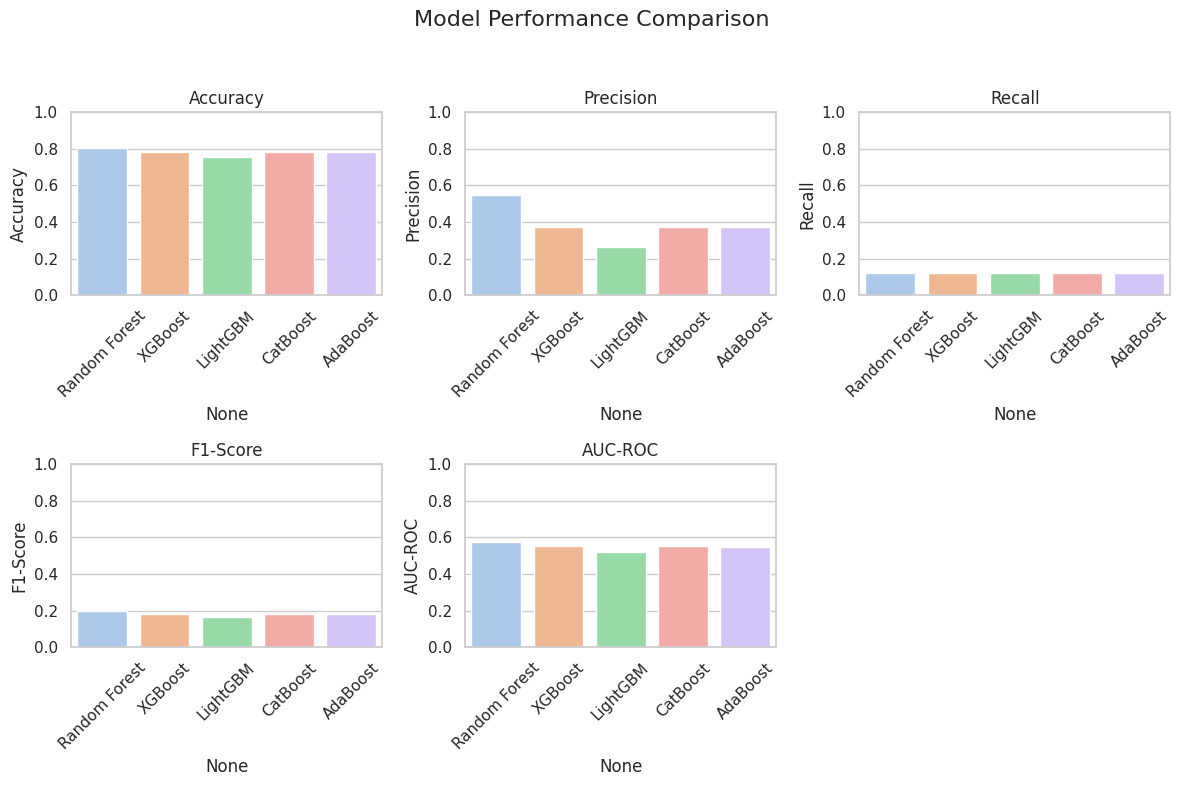

In [37]:
# Set style
sns.set(style="whitegrid")

# Transpose for plotting
results_plot_df = results_df.T

# Plot each metric separately
plt.figure(figsize=(12, 8))
for i, metric in enumerate(results_plot_df.index):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=results_plot_df.columns, y=results_plot_df.loc[metric], palette="pastel")
    plt.title(metric)
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

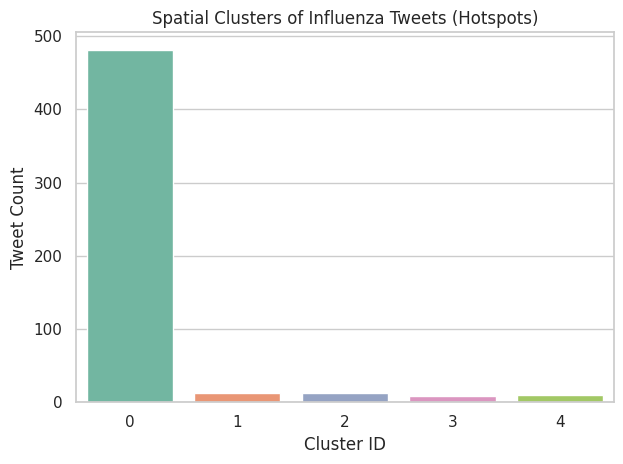

In [38]:
# Convert textual locations to numerical
df['location_encoded'] = LabelEncoder().fit_transform(df['flu_locs'])

# Cluster flu activity by location
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['location_encoded']])

# Plot: Number of flu tweets by cluster
sns.countplot(x='cluster', data=df, palette='Set2')
plt.title("Spatial Clusters of Influenza Tweets (Hotspots)")
plt.xlabel("Cluster ID")
plt.ylabel("Tweet Count")
plt.tight_layout()
plt.show()
